In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.optimize import curve_fit
plt.style.use('default')
from scipy.special import hyp2f1
import re
from tabulate import tabulate

In [2]:
#This function is modified to return Xarray instead of Dictionary. 

def h5_in_xarray(field):
    data = hf.get('%s' % field)
    x1 = hf.get('x-coord')
    x2 = hf.get('y-coord')
    x3 = hf.get('z-coord')
    xr_data = xr.DataArray(
        np.array(data),
        dims = ("x", "y", "z"),
        coords = { "x" : np.array(x1),
                  "y" : np.array(x2),
                  "z" : np.array(x3)
        }   
    )
    
    return xr_data

def create_xarray(u):
    
    # This function creates an xarray that has same data size and coordinates aligned with the input xarray u
    new_array = xr.DataArray(
        np.empty(u.shape),
        dims = ("x", "y", "z"),
        coords = { "x" : u['x'],
              "y" : u['y'],
              "z" : u['z']
        }
    )
    
    return new_array

def output_keylist(f, con1, con2):
    '''
    Arguments--
    f - the dictionary containing all the data
    con1 - what contains in the list (often the packing density)
    con2 - a "startswith condition"
    '''
    key_list = list(f.keys())
    key_list = [match for match in key_list if con1 in match and match.startswith(con2)]
    key_list.sort()
    key_list = key_list[3:] + key_list[0:3]
    if con1 == "l2" or con1 == "l6":
        key_list = key_list[3:4] + key_list[0:3] + key_list[4:]
    
    return key_list

In [3]:
# Let's load the entire data
field_list = ['u', 'v', 'w', 'uu', 'uw']
f = {} # Loads all the variables
h5_files = os.listdir('/Users/erikvanwinkle/Documents/DeSci Labs_files/Marco Node/Node Data/Processed Data/high_reso_new_stl_averages')
h5_files = [match for match in h5_files if "ruw" not in match and "DS_Store" not in match]
filepath = '/Users/erikvanwinkle/Documents/DeSci Labs_files/Marco Node/Node Data/Processed Data/high_reso_new_stl_averages'

for sim in h5_files:
    hf = h5py.File('%s/%s' % (filepath, sim), 'r')
    for field in field_list:
        f['%s%s' % (field, sim[4:-3])] = h5_in_xarray(field)

In [4]:
sim = 'chan_hxsx83e-3_8x36x48.h5'
hf = h5py.File('%s/%s' % (filepath, sim), 'r')
for field in field_list:
    f['%s%s' % (field, sim[4:-3])] = h5_in_xarray(field)

In [5]:
sim = 'chan_hxsx83e-3_4x18x24.h5'
hf = h5py.File('%s/%s' % (filepath, sim), 'r')
for field in field_list:
    f['%s%s' % (field, sim[4:-3])] = h5_in_xarray(field)

### Figure 13

Text(0.06, 0.6, '$\\frac{(x_3 - d)}{L_3}$')

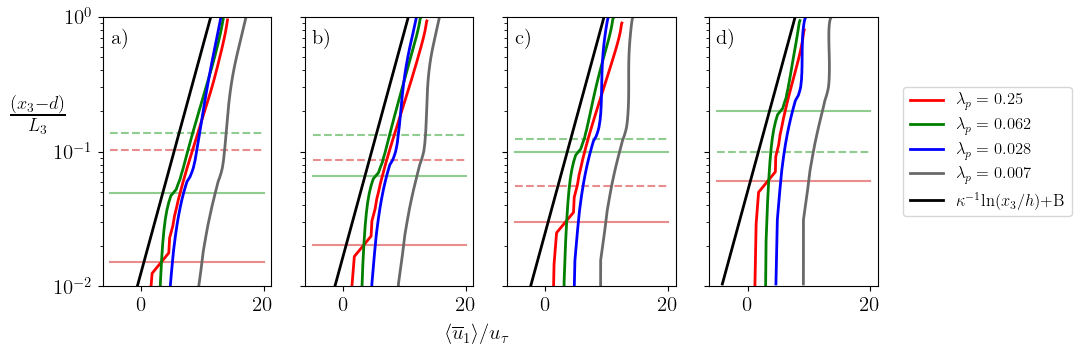

In [6]:
# Getting all the four domain heights in one plot of 4 subplots like the paper template
from matplotlib import rc
import matplotlib
rc('font',weight='bold',size=15,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)

fig1, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)

pack_list = ["l2", "l4", "l6", "l12"]
den_list = [0.25, 0.062, 0.028, 0.007]
domh = ["16", "12", "8", "4"]

d_list2 = [0.75837542125692, 0.20448135561821737, 0, 0]
z0_list2 = [0.06649667492688939, 0.0854966106356029, 0.05056926143920569, 0.009022629531375207]
for index, delta in enumerate(domh):
    delta = int(delta)  
    key_list = []
    for pack_den in pack_list:
        key_list.append(f'u_{pack_den}_{delta}x{delta*3}x{delta*6}')

    
    z_reso = 12
    kappa = 0.384 # Values from Monkewitz paper
    B = 4.17  # These are the values from Monkewitz
    node1 = int(0 * z_reso)
    node2 = int(delta * z_reso)
    
    namelist = ['a)', 'b)', 'c)', 'd)']
    clist = ['r', 'g', 'b', 'dimgrey']
    alfa = 0.53
    axs[index].semilogy(np.linspace(-5, 20, 50), (np.ones(50) - d_list2[0])/delta, color='tab:red', alpha = alfa)
    axs[index].semilogy(np.linspace(-5, 20, 50), (np.ones(50) - d_list2[1])/delta, color='tab:green', alpha = alfa)
    axs[index].semilogy(np.linspace(-5, 20, 50), 0.15 * np.ones(50) - d_list2[0]/delta, color='tab:red', linestyle='dashed', alpha = alfa) #, label='Log law bound')
    axs[index].semilogy(np.linspace(-5, 20, 50), 0.15 * np.ones(50) - d_list2[1]/delta, color='tab:green', linestyle='dashed', alpha = alfa)
    for index1, key in enumerate(key_list):
        col = clist[index1]
        if index == 3:
            axs[index].semilogy((f[key]).mean(dim = ['x', 'y'])[node1:node2], (f[key]['z'][node1:node2] - d_list2[index1])/delta, color=col, linewidth=2, label=f'$\lambda_p = {den_list[index1]}$')
        else:
            axs[index].semilogy((f[key]).mean(dim = ['x', 'y'])[node1:node2], (f[key]['z'][node1:node2] - d_list2[index1])/delta, color=col, linewidth=2, label=f'{pack_den}')
    plt.text(0.1, 0.9, namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    axs[index].set_ylim(0.01, 1)
    
    axs[index].semilogy(np.log(f[key]['z'][node1:node2].values)/kappa + B, f[key]['z'][node1:node2] / delta, 'k', linewidth=2, label=r'$\kappa^{-1}$' + 'ln' + r'$(x_3/h) + $' + 'B')
axs[3].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)
fig1.text(0.5, -0.025, r'$\langle\overline{u}_1\rangle/u_{\tau}$', ha='center', va='center', fontsize=15)
fig1.text(0.06, 0.6, r'$\frac{(x_3 - d)}{L_3}$', ha='center', va='center', rotation='horizontal', fontsize=19)

### Figure 8

Text(0.08, 0.5, '$x_3/h$')

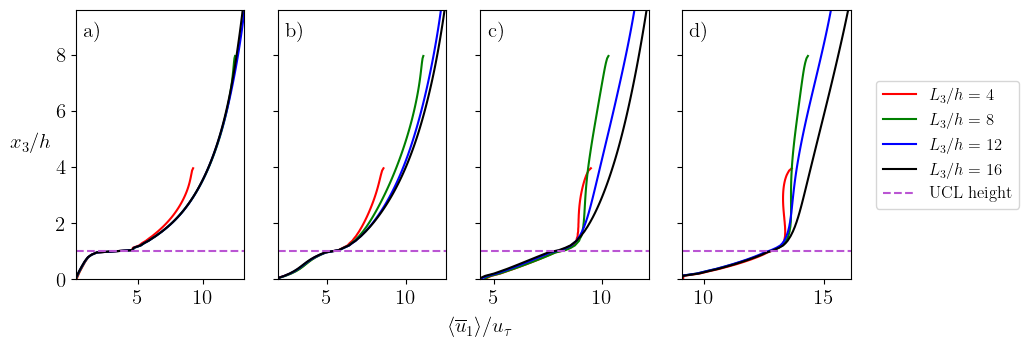

In [7]:
from matplotlib import rc
import matplotlib
plt.style.use('default')
rc('font',weight='bold',size=15,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)

fig1, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)
pattern = re.compile(r'\d+')
pack_list = ["l2", "l4", "l6", "l12"]
for index, pack_den in enumerate(pack_list):   
    key_list = [f'u_{pack_den}_4x12x24', f'u_{pack_den}_8x24x48', f'u_{pack_den}_12x36x72', f'u_{pack_den}_16x48x96']

    namelist = ['a)', 'b)', 'c)', 'd)']
    clist = ['r', 'g', 'b', 'k']
    for index1, key in enumerate(key_list):
        match = pattern.findall(key)
        delta = int(match[1])
        ly = int(match[2])
        if index == 3:
            axs[index].plot((f["%s" % key]).mean(dim = ['x', 'y'])[:120], f["%s" % key]['z'][:120], clist[index1], linewidth=1.5, label=r'$L_3/h = %d$' % int(delta))
        else:
            axs[index].plot((f["%s" % key]).mean(dim = ['x', 'y'])[:120], f["%s" % key]['z'][:120], clist[index1], linewidth=1.5)
    plt.text(0.1, 0.9, namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    axs[index].set_ylim(0, 9.6)
    axs[index].set_xlim((f["%s" % key]).mean(dim = ['x', 'y'])[0].values, (f["%s" % key]).mean(dim = ['x', 'y'])[120].values)
    axs[index].plot(np.linspace((f["%s" % key]).mean(dim = ['x', 'y'])[0].values, (f["%s" % key]).mean(dim = ['x', 'y'])[120].values, 20), np.ones(20), color='mediumorchid', linestyle='dashed', linewidth=1.5, label='UCL height')
axs[3].legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)
fig1.text(0.53, -0.025, r'$\langle\overline{u}_1\rangle/u_{\tau}$', ha='center', va='center', fontsize=15)
fig1.text(0.08, 0.5, r'$x_3/h$', ha='center', va='center', rotation='horizontal', fontsize=15)

### Figure 11

In [8]:
def output_d_kanda2(pack_den):
    "highest values"
    if pack_den == "500":
        return 0.77
    if pack_den == "250":
        return 0.4
    if pack_den == "167":
        return 0.06
    if pack_den == "83":
        return 0

def plot_firstorder_outer_defect(pack_den, ax1, clist, namelist, index):
    # fig1 = plt.figure()
    key_list = [f'u_hxsx{pack_den}e-3_4x12x24', f'u_hxsx{pack_den}e-3_8x24x48', f'u_hxsx{pack_den}e-3_12x36x72', f'u_hxsx{pack_den}e-3_16x48x96']

    if pack_den == '83':
        key_list = [f'u_hxsx{pack_den}e-3_4x18x24', f'u_hxsx{pack_den}e-3_8x36x48', f'u_hxsx{pack_den}e-3_12x36x72', f'u_hxsx{pack_den}e-3_16x48x96']
    for index1, key in enumerate(key_list):
        match = pattern.findall(key)
        delta = int(match[2])
        d = output_d_kanda2(pack_den)
        rsl_height = float(1000/int(pack_den)/16) * delta / 2 + d
        rsl_height_16 = float(1000/int(pack_den)/16) * 16 / 2 + d
        rsl_node = round(rsl_height * 12)
        rsl_node_16 = round(rsl_height_16 * 12)

        if pack_den == '83' and '_8x' in key:
            rsl_node = round(rsl_height * 8)
            rsl_node_16 = round(rsl_height_16 * 8)

        if pack_den == '83' and '_4x' in key:
            rsl_node = round(rsl_height * 8)
            rsl_node_16 = round(rsl_height_16 * 8)

        if index==3:
            ax1.plot(((f["%s" % key]).mean(dim = ['x', 'y']).max() - (f["%s" % key]).mean(dim = ['x', 'y']))[rsl_node:], (f["%s" % key]['z'][rsl_node:] - rsl_height) / (delta - rsl_height), clist[index1], linewidth=2, label=r'$L_3/h = %d$' % int(delta))
        else:
            ax1.plot(((f["%s" % key]).mean(dim = ['x', 'y']).max() - (f["%s" % key]).mean(dim = ['x', 'y']))[rsl_node:], (f["%s" % key]['z'][rsl_node:] - rsl_height) / (delta - rsl_height), clist[index1], linewidth=2)

    if index==3:
        ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)

['u_hxsx500e-3_4x12x24', 'u_hxsx500e-3_8x24x48', 'u_hxsx500e-3_12x36x72', 'u_hxsx500e-3_16x48x96']
['u_hxsx250e-3_4x12x24', 'u_hxsx250e-3_8x24x48', 'u_hxsx250e-3_12x36x72', 'u_hxsx250e-3_16x48x96']
['u_hxsx167e-3_4x12x24', 'u_hxsx167e-3_8x24x48', 'u_hxsx167e-3_12x36x72', 'u_hxsx167e-3_16x48x96']
['u_hxsx83e-3_4x18x24', 'u_hxsx83e-3_8x36x48', 'u_hxsx83e-3_12x36x72', 'u_hxsx83e-3_16x48x96']


Text(0.06, 0.5, '$\\frac{x_3-x_{3r}}{L_3-x_{3r}}$')

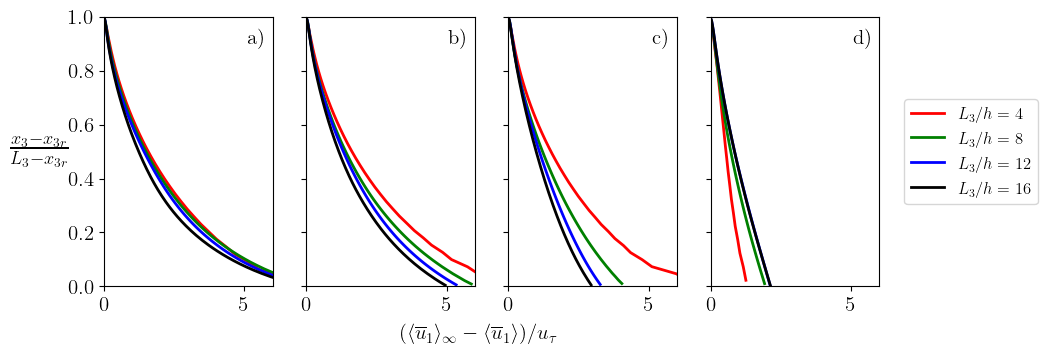

In [9]:
from matplotlib import rc
rc('font',weight='bold',size=15,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)
pattern = re.compile(r'\d+')
fig1, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)
namelist = ['a)', 'b)', 'c)', 'd)']
clist = ['r', 'g', 'b', 'k']
pack_list = ["500", "250", "167", "83"]
for index, pack_den in enumerate(pack_list):
    plot_firstorder_outer_defect(pack_den, axs[index], clist, namelist, index)
    fig1.text(0.9, 0.9, r'%s' % namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    axs[index].set_ylim(0, 1)
    axs[index].set_xlim(0, 6)
fig1.text(0.5, -0.025, r'$(\langle \overline{u}_{1}\rangle_{\infty} - \langle\overline{u}_1\rangle)/u_{\tau}$', ha='center', va='center', fontsize=15)
fig1.text(0.06, 0.5, r'$\frac{x_3-x_{3r}}{L_3-x_{3r}}$', ha='center', va='center', rotation='horizontal', fontsize=19)


### Computing 2nd order statistics

In [10]:
var_list = ['uu', 'uw']
h5_files += ['chan_hxsx83e-3_8x36x48.h5', 'chan_hxsx83e-3_4x18x24.h5']

temp = {}

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        temp["%s%s" % (v, sim)] = f["%s%s" % (v, sim)].mean(dim = ['x', 'y']) - (f["%s%s" % (v[0], sim)] * f["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y'])

disp = {}

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        disp["%s%s" % (v, sim)] = (f["%s%s" % (v[0], sim)]*f["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y']) - f["%s%s" % (v[0], sim)].mean(dim = ['x', 'y']) * f["%s%s" % (v[1], sim)].mean(dim = ['x', 'y'])

stress = {}

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        stress["%s%s" % (v, sim)] = temp["%s%s" % (v, sim)] + disp["%s%s" % (v, sim)]

In [11]:
# To load the ww stress
field_list = ['w', 'ww']
g = {} # Loads all the variables
h5_files = os.listdir('/Users/erikvanwinkle/Documents/DeSci Labs_files/Marco Node/Node Data/Processed Data/high_reso_w')
h5_files = [match for match in h5_files if "ruw" not in match and "DS_Store" not in match]
filepath = '/Users/erikvanwinkle/Documents/DeSci Labs_files/Marco Node/Node Data/Processed Data/high_reso_w'

for sim in h5_files:
    hf = h5py.File('%s/%s' % (filepath, sim), 'r')
    for field in field_list:
        g['%s%s' % (field, sim[4:-3])] = h5_in_xarray(field)

var_list = ['ww']
for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        temp["%s%s" % (v, sim)] = g["%s%s" % (v, sim)].mean(dim = ['x', 'y']) - (g["%s%s" % (v[0], sim)] * g["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y'])

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        disp["%s%s" % (v, sim)] = (g["%s%s" % (v[0], sim)]*g["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y']) - g["%s%s" % (v[0], sim)].mean(dim = ['x', 'y']) * g["%s%s" % (v[1], sim)].mean(dim = ['x', 'y'])

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        stress["%s%s" % (v, sim)] = temp["%s%s" % (v, sim)] + disp["%s%s" % (v, sim)]


In [13]:
h5_files = ['chan_hxsx83e-3_8x36x48.h5', 'chan_hxsx83e-3_4x18x24.h5']
filepath = '/Users/erikvanwinkle/Documents/DeSci Labs_files/Marco Node/Node Data/Processed Data/high_reso_new_stl_averages'

for sim in h5_files:
    hf = h5py.File('%s/%s' % (filepath, sim), 'r')
    for field in field_list:
        g['%s%s' % (field, sim[4:-3])] = h5_in_xarray(field)

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        temp["%s%s" % (v, sim)] = g["%s%s" % (v, sim)].mean(dim = ['x', 'y']) - (g["%s%s" % (v[0], sim)] * g["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y'])

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        disp["%s%s" % (v, sim)] = (g["%s%s" % (v[0], sim)]*g["%s%s" % (v[1], sim)]).mean(dim = ['x', 'y']) - g["%s%s" % (v[0], sim)].mean(dim = ['x', 'y']) * g["%s%s" % (v[1], sim)].mean(dim = ['x', 'y'])

for sim in h5_files:
    sim = sim[4:-3]
    for v in var_list:
        stress["%s%s" % (v, sim)] = temp["%s%s" % (v, sim)] + disp["%s%s" % (v, sim)]

### Figure 10

Text(0.07, 0.5, '$x_3/h$')

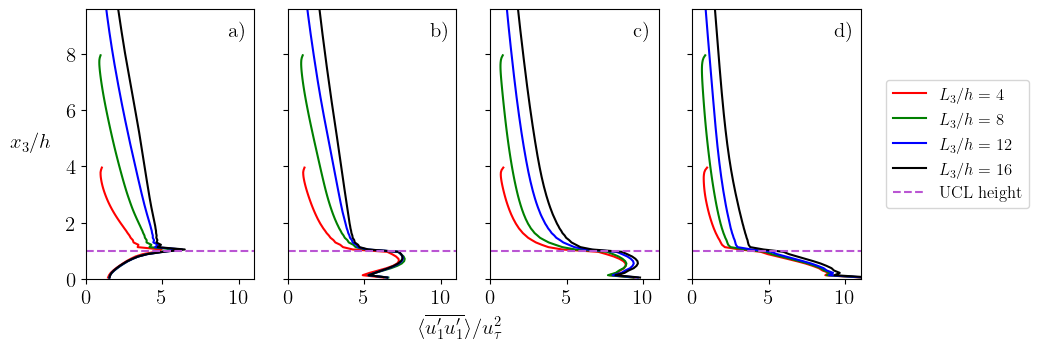

In [14]:
def output_d_kanda2_l(pack_den):
    "highest values"
    if pack_den == "l2":
        return 0.77
    if pack_den == "l4":
        return 0.4
    if pack_den == "l6":
        return 0.06
    if pack_den == "l12":
        return 0
    
def plot_secondorder_hscaling(pack_den, ax1, clist, namelist, index, var="uu"):

    key_list = [f'uu_{pack_den}_4x12x24', f'uu_{pack_den}_8x24x48', f'uu_{pack_den}_12x36x72', f'uu_{pack_den}_16x48x96']
    for index1, key in enumerate(key_list):
        match = pattern.findall(key)
        delta = int(match[1])
        
        ax1.plot(stress["%s" % key], stress["%s" % key]['z'], clist[index1], linewidth=1.5, label=r'$L_3/h = %d$' % int(delta))
    ax1.set_xlim(0, 11)
    ax1.set_ylim(0, 16)
    ax1.set_xticks([0, 5, 10])
    ax1.plot(np.linspace(0, 16, 20), np.ones(20), color='mediumorchid', linestyle='dashed', linewidth=1.5, label='UCL height')
    if index==3:
        ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)

from matplotlib import rc
import matplotlib
rc('font',weight='bold',size=15,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)
pattern = re.compile(r'\d+')
fig1, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)
namelist = ['a)', 'b)', 'c)', 'd)']
clist = ['r', 'g', 'b', 'k']
pack_list = ["l2", "l4", "l6", "l12"]
for index, pack_den in enumerate(pack_list):
    plot_secondorder_hscaling(pack_den, axs[index], clist, namelist, index)
    fig1.text(0.9, 0.9, r'%s' % namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    axs[index].set_ylim(0, 9.6)
fig1.text(0.5, -0.025, r'$\langle\overline{u_1^\prime u_1^\prime}\rangle/u^2_{\tau}$', ha='center', va='center', fontsize=15)
fig1.text(0.07, 0.5, r'$x_3/h$', ha='center', va='center', rotation='horizontal', fontsize=15)


### Figure 12

In [15]:
def plot_secondorder_outerscaling2(pack_den, ax1, clist, namelist, index, var="uu"):

    key_list = [f'uu_hxsx{pack_den}e-3_4x12x24', f'uu_hxsx{pack_den}e-3_8x24x48', f'uu_hxsx{pack_den}e-3_12x36x72', f'uu_hxsx{pack_den}e-3_16x48x96']

    if pack_den == '83':
        key_list = [f'uu_hxsx{pack_den}e-3_4x18x24', f'uu_hxsx{pack_den}e-3_8x36x48', f'uu_hxsx{pack_den}e-3_12x36x72', f'uu_hxsx{pack_den}e-3_16x48x96']
    for index1, key in enumerate(key_list):
        match = pattern.findall(key)
        delta = int(match[2])
        d = output_d_kanda2(pack_den)
        rsl_height = float(1000/int(pack_den)/16) * delta / 2 + d
        rsl_node = round(rsl_height * 12)

        if pack_den == '83' and '_8x' in key:
            rsl_node = round(rsl_height * 8)

        if pack_den == '83' and '_4x' in key:
            rsl_node = round(rsl_height * 8)
        
        ax1.plot(stress["%s" % key][rsl_node:], (stress["%s" % key]['z'][rsl_node:] - rsl_height) / (delta - rsl_height), clist[index1], linewidth=2, label=r'$L_3/h = %d$' % int(delta))
        
    if index==3:
        ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12)

['uu_hxsx500e-3_4x12x24', 'uu_hxsx500e-3_8x24x48', 'uu_hxsx500e-3_12x36x72', 'uu_hxsx500e-3_16x48x96']
['uu_hxsx250e-3_4x12x24', 'uu_hxsx250e-3_8x24x48', 'uu_hxsx250e-3_12x36x72', 'uu_hxsx250e-3_16x48x96']
['uu_hxsx167e-3_4x12x24', 'uu_hxsx167e-3_8x24x48', 'uu_hxsx167e-3_12x36x72', 'uu_hxsx167e-3_16x48x96']
['uu_hxsx83e-3_4x18x24', 'uu_hxsx83e-3_8x36x48', 'uu_hxsx83e-3_12x36x72', 'uu_hxsx83e-3_16x48x96']


Text(0.06, 0.5, '$\\frac{x_3-x_{3r}}{L_3-x_{3r}}$')

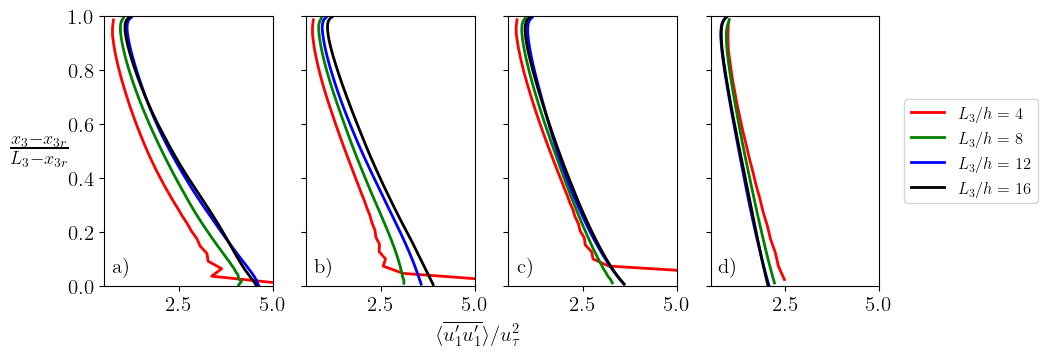

In [16]:
from matplotlib import rc
import matplotlib
rc('font',weight='bold',size=15,family='serif',serif='Computer Modern Roman')
rc('text', usetex=True)
pattern = re.compile(r'\d+')
fig1, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 3.5), sharey=True)
namelist = ['a)', 'b)', 'c)', 'd)']
clist = ['r', 'g', 'b', 'k']
pack_list = ["500", "250", "167", "83"]
for index, pack_den in enumerate(pack_list):
    plot_secondorder_outerscaling2(pack_den, axs[index], clist, namelist, index)
    fig1.text(0.1, 0.05, r'%s' % namelist[index], horizontalalignment='center', transform=axs[index].transAxes,fontsize=15)
    axs[index].set_ylim(0, 1)
    axs[index].set_xlim(0.5, 5)
fig1.text(0.5, -0.025, r'$\langle\overline{u_1^\prime u_1^\prime}\rangle/u^2_{\tau}$', ha='center', va='center', fontsize=15)
fig1.text(0.06, 0.5, r'$\frac{x_3-x_{3r}}{L_3-x_{3r}}$', ha='center', va='center', rotation='horizontal', fontsize=19)